#Info

https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations

**Dataset Description**

For this challenge you are given the purchase history of customers across time, along with supporting metadata. Your challenge is to predict what articles each customer will purchase in the 7-day period immediately after the training data ends. Customer who did not make any purchase during that time are excluded from the scoring.

**Files**

* **images/** - a folder of images corresponding to each `article_id`; images are placed in subfolders starting with the first three digits of the `article_id`; note, not all article_id values have a corresponding image.
* **articles.csv** - detailed metadata for each `article_id` available for purchase
* **customers.csv** - metadata for each `customer_id` in dataset
* **sample_submission.csv** - a sample submission file in the correct format
* **transactions_train.csv** - the training data, consisting of the purchases each customer for each date, as well as additional information. Duplicate rows correspond to multiple purchases of the same item. Your task is to predict the `article_ids` each customer will purchase during the 7-day period immediately after the training data period.

**NOTE:** You must make predictions for all customer_id values found in the sample submission. All customers who made purchases during the test period are scored, regardless of whether they had purchase history in the training data.

# Init

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')
pd.set_option('display.float_format', '{:.4f}'.format)

In [2]:
!gdown --id 1TLRqyRE1rVCSaQpMoSJ4dYfrI7iKXZHP

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1TLRqyRE1rVCSaQpMoSJ4dYfrI7iKXZHP
To: /content/h-and-m-personalized-fashion-recommendations.zip
100% 716M/716M [00:04<00:00, 172MB/s]


In [3]:
!unzip '/content/h-and-m-personalized-fashion-recommendations.zip'

Archive:  /content/h-and-m-personalized-fashion-recommendations.zip
replace h-and-m-personalized-fashion-recommendations/articles.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
df_art = pd.read_csv('/content/h-and-m-personalized-fashion-recommendations/articles.csv')
df_cst = pd.read_csv('/content/h-and-m-personalized-fashion-recommendations/customers.csv')
df_trns = pd.read_csv('/content/h-and-m-personalized-fashion-recommendations/transactions_train.csv')

In [5]:
df_trns['customer_id'] = df_trns['customer_id'].astype('category')

#EDA

## Atricles

In [6]:
df_art.sample(3)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
92611,854590009,854590,Stina sandal SG,91,Sandals,Shoes,1010001,All over pattern,50,Other Pink,...,Kids Girl Shoes,J,"Children Accessories, Swimwear",4,Baby/Children,42,Kids & Baby Shoes,1020,Shoes,Sandals in patterned ethylene-vinyl acetate wi...
89861,840351004,840351,Cilla tube,253,Vest top,Garment Upper body,1010016,Solid,19,Greenish Khaki,...,Basic 1,D,Divided,2,Divided,51,Divided Basics,1002,Jersey Basic,Tube top in ribbed cotton jersey with elastica...
5299,493814045,493814,JACK fancy hood SB,308,Hoodie,Garment Upper body,1010001,All over pattern,14,Dark Beige,...,Kids Boy Jersey Basic,H,Children Sizes 92-140,4,Baby/Children,72,Boys Underwear & Basics,1002,Jersey Basic,Hooded jacket in sweatshirt fabric with a zip ...


In [7]:
a = {}
for col in df_art.columns:
  a[col] = df_art[col].nunique()

pd.DataFrame(list(a.items()), columns=['Key', 'nunique'])

,Key,nunique
0,article_id,105542
1,product_code,47224
2,prod_name,45875
3,product_type_no,132
4,product_type_name,131
5,product_group_name,19
6,graphical_appearance_no,30
7,graphical_appearance_name,30
8,colour_group_code,50
9,colour_group_name,50


## Trancsactions

In [8]:
df_trns.sample(7)

,t_dat,customer_id,article_id,price,sales_channel_id
4365735,2018-12-30,5a70e2e1985ccc3d9a9b22cb3f49dff899e502cce0e5ed...,636587014,0.0068,1
2629984,2018-11-19,06303b5a40b236cdbc8522669d649e2b45c9647bcf9036...,562245001,0.0237,2
12342609,2019-06-22,309a247df13c1ff155650faaceaa5fd23e785e118bfdb2...,666354005,0.0339,2
18955715,2019-11-14,944d65ee8002b900f1f584c0f905ab13ed011c3fff9d4f...,766829001,0.0381,2
9677210,2019-05-02,335459390968f107315f619447a988ddca779a9ce1b313...,678696001,0.0236,1
12763669,2019-06-26,dcc39074bfef4032d8d9ff6b1ab92c0bce90020f50ba20...,721063009,0.0305,2
16681091,2019-09-16,b23cfe4425dbd058cf576d719a8ad59bdea43d123461e3...,723084001,0.0169,2


In [9]:
%%time
a = {}
for col in df_trns.columns:
  a[col] = df_trns[col].nunique()

pd.DataFrame(list(a.items()), columns=['Col', 'nunique'])

CPU times: user 3.01 s, sys: 168 ms, total: 3.18 s
Wall time: 3.52 s


,Col,nunique
0,t_dat,734
1,customer_id,1362281
2,article_id,104547
3,price,9857
4,sales_channel_id,2


In [10]:
df_trns['price'].describe()

count   31788324.0000
mean           0.0278
std            0.0192
min            0.0000
25%            0.0158
50%            0.0254
75%            0.0339
max            0.5915
Name: price, dtype: float64

In [11]:
df_trns.shape[0]

31788324

In [12]:
df_trns.isna().mean()

t_dat              0.0000
customer_id        0.0000
article_id         0.0000
price              0.0000
sales_channel_id   0.0000
dtype: float64

In [13]:
df_trns['t_dat'] = pd.to_datetime(df_trns['t_dat'])

In [14]:
pd.DataFrame(df_trns.groupby(pd.Grouper(key='t_dat', freq='M'))['price'].count()).reset_index()

,t_dat,price
0,2018-09-30,594776
1,2018-10-31,1397040
2,2018-11-30,1270619
3,2018-12-31,1148827
4,2019-01-31,1263471
5,2019-02-28,1152412
6,2019-03-31,1286750
7,2019-04-30,1476454
8,2019-05-31,1560319
9,2019-06-30,1906202


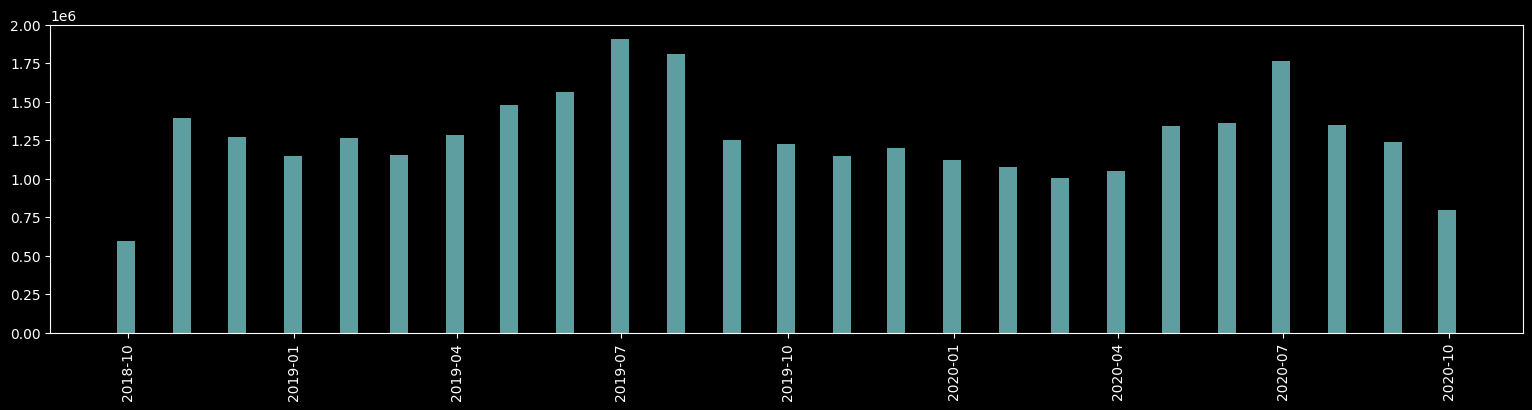

In [15]:
temp3 = pd.DataFrame(df_trns[['t_dat', 'price']].groupby(pd.Grouper(key='t_dat', freq='M'))['price'].count()).reset_index()

f, ax = plt.subplots(1, 1, figsize=(19, 4))

ax.bar(temp3['t_dat'], temp3['price'], linewidth=4, color='cadetblue', width=10)
plt.xticks(rotation=90);

In [16]:
df_trns = df_trns.merge(df_art[['article_id', 'prod_name', 'product_group_name', 'graphical_appearance_name', 'product_type_name', 'garment_group_name', 'index_group_name']], on='article_id', how='left')

In [17]:
df_trns.head()

,t_dat,customer_id,article_id,price,sales_channel_id,prod_name,product_group_name,graphical_appearance_name,product_type_name,garment_group_name,index_group_name
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.0508,2,Atlanta Push Body Harlow,Underwear,Solid,Underwear body,"Under-, Nightwear",Ladieswear
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.0305,2,Rae Push (Melbourne) 2p,Underwear,Solid,Bra,"Under-, Nightwear",Ladieswear
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.0152,2,Inca Jumper,Garment Upper body,Melange,Sweater,Knitwear,Divided
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.0169,2,W YODA KNIT OL OFFER,Garment Upper body,Melange,Sweater,Special Offers,Ladieswear
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.0169,2,W YODA KNIT OL OFFER,Garment Upper body,Melange,Sweater,Special Offers,Ladieswear


In [18]:
df_trns.groupby(['product_group_name', 'product_type_name']).agg({'price': ['sum', 'mean', 'count' ]}).sort_values(('price', 'sum'), ascending=False).head(10)

price                
                                             sum   mean    count
product_group_name product_type_name                            
Garment Lower body Trousers          150908.0462 0.0358  4217017
Garment Full body  Dress             118185.7966 0.0365  3238428
Garment Upper body Sweater            80732.9829 0.0290  2783274
                   Blouse             42424.6305 0.0282  1504868
                   Jacket             40422.7620 0.0674   600157
Garment Lower body Skirt              33230.4771 0.0356   934338
Garment Upper body Top                32120.5338 0.0203  1583408
Underwear          Bra                31987.6368 0.0240  1335233
Garment Upper body T-shirt            30274.8772 0.0137  2203750
Garment Lower body Shorts             26973.2062 0.0234  1152513

In [19]:
%%time
t = df_trns[df_trns['product_group_name'] == 'Garment Lower body']

temp = pd.DataFrame(t[['t_dat', 'price']].groupby(pd.Grouper(key='t_dat', freq='M'))['price'].mean())
temp1 = pd.DataFrame(t[['t_dat', 'price']].groupby(pd.Grouper(key='t_dat', freq='M'))['price'].std().fillna(0))

CPU times: user 3.89 s, sys: 414 ms, total: 4.3 s
Wall time: 4.3 s


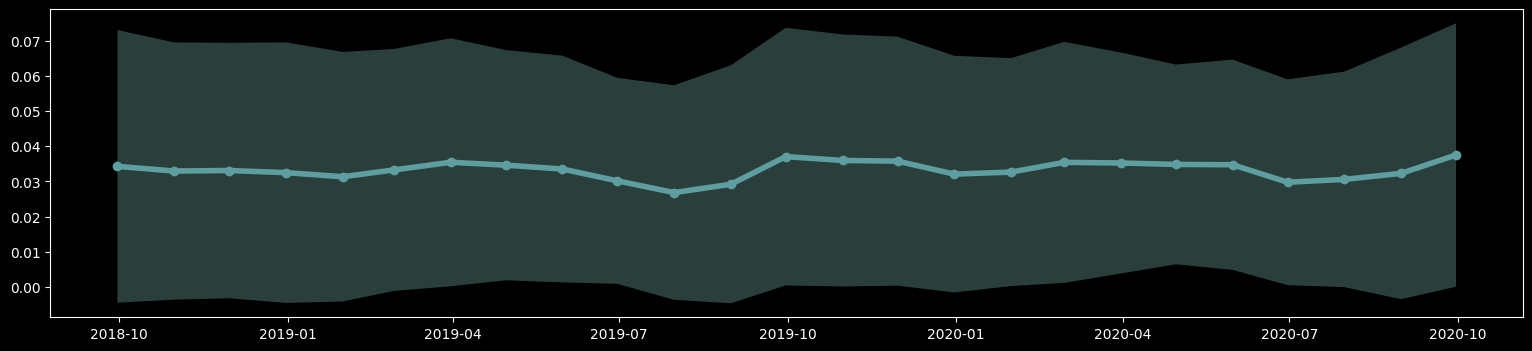

In [20]:
f, ax = plt.subplots(1, 1, figsize=(19, 4))

ax.plot(temp, linewidth=4, c='cadetblue', marker='o')
ax.fill_between(temp.index,
                (temp.values + 2*temp1.values).ravel(),
                (temp.values - 2*temp1.values).ravel(),
                alpha=0.3
              )

In [21]:
trns_1kcustomer = df_trns.groupby(['customer_id'], as_index=False).agg({'price': 'sum'}).sort_values('price', ascending=False)[:1000]['customer_id']

In [22]:
trns_1kcustomer.head(3)

1011710    be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee9...
885174     a65f77281a528bf5c1e9f270141d601d116e1df33bf9df...
20162      03d0011487606c37c1b1ed147fc72f285a50c05f00b971...
Name: customer_id, dtype: category
Categories (1362281, object): [,
                               '00000dbacae5abe5e23885899a1fa44253a17956c6d1c...,
                               '0000423b00ade91418cceaf3b26c6af3dd342b51fd051...,
                               '000058a12d5b43e67d225668fa1f8d618c13dc232df0c...,
                               '00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd..., ...,
                               'ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab...,
                               'ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a...,
                               'ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe3...,
                               'ffffd9ac14e89946416d80e791d064701994755c3ab68...]

In [23]:
df_trns[df_trns['customer_id'].isin(trns_1kcustomer)].sample(5)

,t_dat,customer_id,article_id,price,sales_channel_id,prod_name,product_group_name,graphical_appearance_name,product_type_name,garment_group_name,index_group_name
29712505,2020-07-30,f8760c15cf72e2856f7895d6165887ca5a75cf1e5aba2f...,887659008,0.0082,2,Carla top,Garment Upper body,Solid,T-shirt,Jersey Basic,Divided
19424306,2019-11-28,a13f92a54d578aa16f574be5b4f94493142d7019e1c7c4...,825733002,0.0244,2,Pointer,Garment Upper body,Solid,Sweater,Knitwear,Ladieswear
7022184,2019-03-06,3eab1a0a201afb2b53894d97b5b9eff45ea0e09a90df7e...,619764005,0.0169,2,Marie 7-p. ankle sock,Socks & Tights,Other pattern,Socks,Socks and Tights,Baby/Children
11673838,2019-06-11,a03f1c2b51f6654449de9119d16b64ce8f0272406c659c...,723874001,0.0339,2,Marielle sandalette,Shoes,Solid,Heeled sandals,Shoes,Ladieswear
29914641,2020-08-04,a5980b988e53ca59e5ae50af0835f2b66c231d4bac3543...,838340003,0.0081,2,Alicante HW Dry cotton Pull-on,Garment Lower body,Solid,Trousers,Trousers,Divided


In [24]:
t = df_trns.groupby(['index_group_name', 'garment_group_name'], as_index=False, dropna=False).agg({'price': 'sum'}).sort_values('price', ascending=False)

In [25]:
t.groupby(['garment_group_name'])['price'].sum().sort_values(ascending=False)[:8]

garment_group_name
Jersey Fancy        122411.9834
Trousers            102068.2251
Dresses Ladies       77701.2975
Knitwear             77145.9625
Blouses              71284.9614
Under-, Nightwear    63542.0953
Swimwear             56249.9335
Trousers Denim       51955.6990
Name: price, dtype: float64

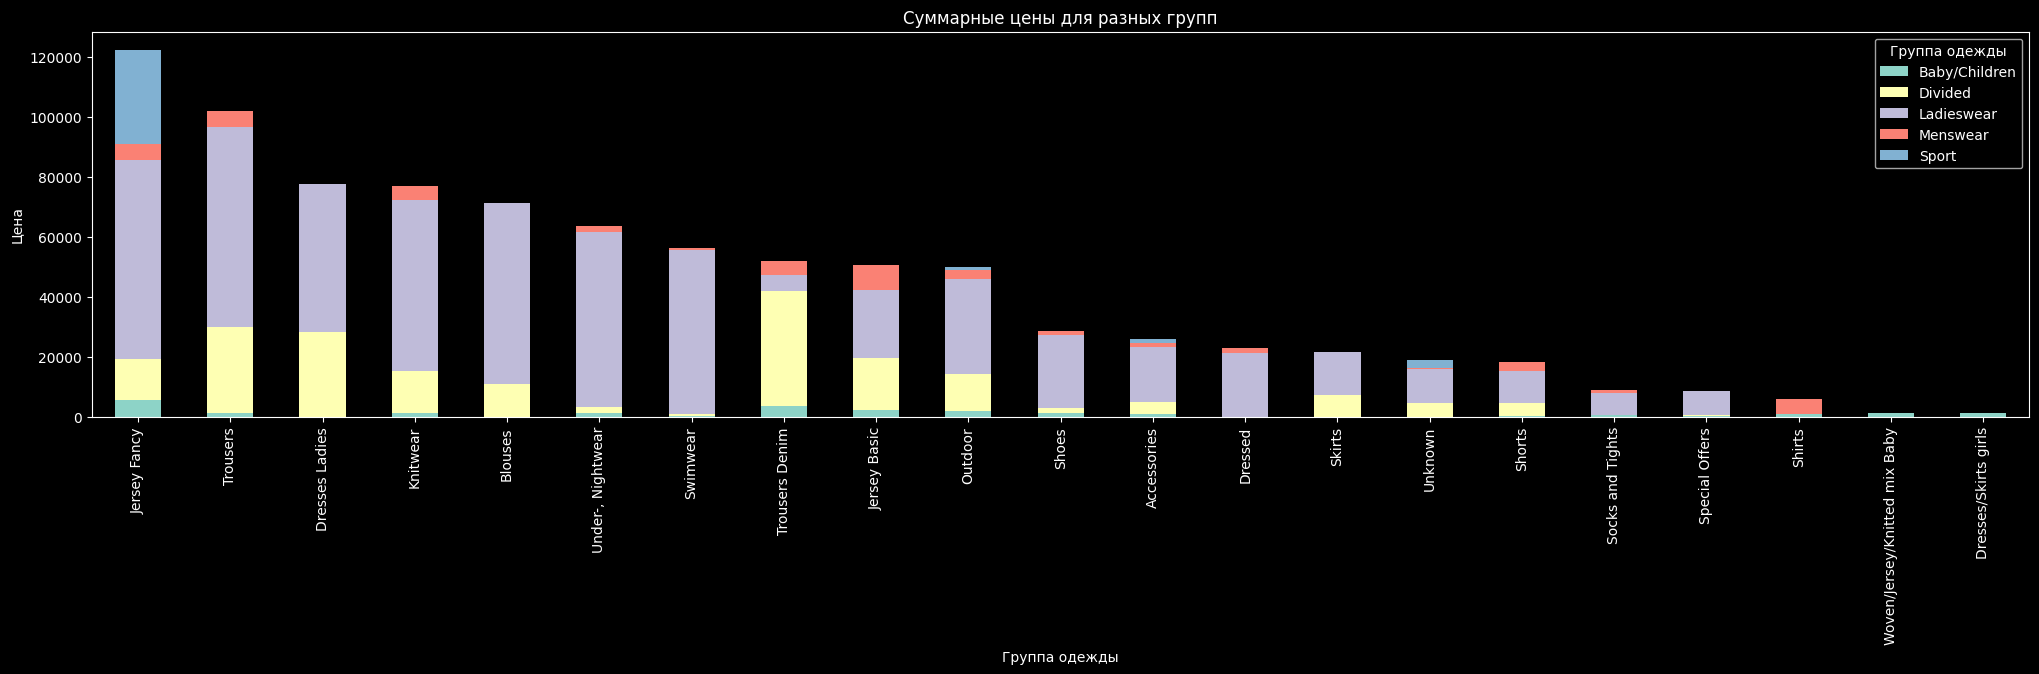

In [26]:
# Группировка данных по 'index_group_name' и 'garment_group_name', а затем суммирование цен
grouped_data = t.groupby(['index_group_name', 'garment_group_name']).sum()

# Распаковка индекса после группировки для удобства
grouped_data = grouped_data.reset_index()

# Создание столбчатой диаграммы
grouped_data = grouped_data.pivot(index='garment_group_name', columns='index_group_name', values='price')

# Создаем итоговый столбец, сортируем по нему, удаляем
grouped_data['Total'] = grouped_data.sum(axis=1)
grouped_data = grouped_data.sort_values(by='Total', ascending=False)
grouped_data = grouped_data.drop('Total', axis=1)

grouped_data.plot.bar(stacked=True, figsize=(25, 5))

plt.xticks(rotation=90)

# Настройка меток и заголовка
plt.xlabel('Группа одежды')
plt.ylabel('Цена')
plt.title('Суммарные цены для разных групп')

# Добавление легенды
plt.legend(title='Группа одежды', loc='upper right')

# Система рекомендаций

In [27]:
trns_1kcustomer.head(3)

1011710    be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee9...
885174     a65f77281a528bf5c1e9f270141d601d116e1df33bf9df...
20162      03d0011487606c37c1b1ed147fc72f285a50c05f00b971...
Name: customer_id, dtype: category
Categories (1362281, object): [,
                               '00000dbacae5abe5e23885899a1fa44253a17956c6d1c...,
                               '0000423b00ade91418cceaf3b26c6af3dd342b51fd051...,
                               '000058a12d5b43e67d225668fa1f8d618c13dc232df0c...,
                               '00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd..., ...,
                               'ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab...,
                               'ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a...,
                               'ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe3...,
                               'ffffd9ac14e89946416d80e791d064701994755c3ab68...]

In [28]:
df_trns_small = df_trns[df_trns['customer_id'].isin(trns_1kcustomer)].copy()

In [29]:
dict_id_1000 = {id: i for i, id in enumerate(trns_1kcustomer)}
dict_id_1000_rev = {i: id for i, id in enumerate(trns_1kcustomer)}

In [30]:
dict_id_1000_rev[4]

'b4db5e5259234574edfff958e170fe3a5e13b6f146752ca066abca3c156acc71'

In [31]:
df_trns_small

,t_dat,customer_id,article_id,price,sales_channel_id,prod_name,product_group_name,graphical_appearance_name,product_type_name,garment_group_name,index_group_name
740,2018-09-20,03d0011487606c37c1b1ed147fc72f285a50c05f00b971...,668766002,0.0424,2,Roger,Garment Upper body,Solid,Blouse,Blouses,Ladieswear
741,2018-09-20,03d0011487606c37c1b1ed147fc72f285a50c05f00b971...,652946001,0.0508,2,&DENIM Bootcut RW Speed,Garment Lower body,Denim,Trousers,Trousers Denim,Ladieswear
742,2018-09-20,03d0011487606c37c1b1ed147fc72f285a50c05f00b971...,691275008,0.0678,2,Waves blouse,Garment Upper body,Solid,Blouse,Blouses,Ladieswear
1260,2018-09-20,06d23b72cac134851a761473b40c881c300814981b6b0a...,657476001,0.0169,2,London 9.99,Garment Upper body,Placement print,T-shirt,Jersey Fancy,Divided
1261,2018-09-20,06d23b72cac134851a761473b40c881c300814981b6b0a...,685687003,0.0169,2,W YODA KNIT OL OFFER,Garment Upper body,Melange,Sweater,Special Offers,Ladieswear
...,...,...,...,...,...,...,...,...,...,...,...
31787270,2020-09-22,f73d6929512e30c00e2ad183623dc44d983085800953b8...,870982002,0.0678,2,Tina fur,Garment Upper body,Solid,Outdoor Waistcoat,Outdoor,Divided
31787271,2020-09-22,f73d6929512e30c00e2ad183623dc44d983085800953b8...,911061004,0.0305,2,Hello cross,Accessories,Other structure,Bag,Accessories,Ladieswear
31787272,2020-09-22,f73d6929512e30c00e2ad183623dc44d983085800953b8...,887303001,0.0763,2,Nova biker speed,Garment Upper body,Solid,Jacket,Outdoor,Baby/Children
31788051,2020-09-22,fd92295ad4e481896b76c303a7b403dc88b4853bb4504b...,905949001,0.0339,2,Orangerie,Garment Upper body,Solid,Vest top,Blouses,Ladieswear


In [32]:
from tqdm import tqdm
tqdm.pandas()

def repalce(x):
  try:
    res = dict_id_1000[x['customer_id']]
  except Exception as e:
    res = -1
  return res
#(lambda x: dict_id_1000[x['customer_id']])

df_trns_small['customer_id_2'] = df_trns_small.progress_apply(repalce, axis=1)

100%|██████████| 504309/504309 [00:06<00:00, 73230.10it/s] 


In [33]:
grouped = df_trns_small.groupby(['customer_id_2', 'article_id'])['article_id'].count()

In [34]:
grouped

customer_id_2  article_id
0              110065011     1
               156231001     1
               160442007     1
               160442010     4
               186262001     1
                            ..
999            917434001     1
               927791004     1
               931437001     2
               932365005     1
               934380001     1
Name: article_id, Length: 370392, dtype: int64

In [35]:
matrix = grouped.unstack('article_id')

In [36]:
matrix

article_id,108775015,108775044,110065001,110065002,110065011,111565001,111586001,111593001,111609001,114428030,...,946827001,946827002,947509001,947934001,949198001,949551001,949551002,952267001,953763001,956217002
customer_id_2,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,1.0000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,2.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
tqdm.pandas()
matrix = matrix.progress_applymap(lambda x: 1 if x > 0 else 0)

100%|██████████| 57031000/57031000 [01:47<00:00, 532526.57it/s]


In [125]:
matrix

article_id,108775015,108775044,110065001,110065002,110065011,111565001,111586001,111593001,111609001,114428030,...,946827001,946827002,947509001,947934001,949198001,949551001,949551002,952267001,953763001,956217002
customer_id_2,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [126]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(matrix, matrix)

In [127]:
cosine_sim_df = pd.DataFrame(cosine_sim)

cosine_sim_df.columns = matrix.index

cosine_sim_df.head(20)

customer_id_2,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.0000,0.0217,0.0317,0.0355,0.0500,0.0598,0.0216,0.0267,0.0262,0.0391,...,0.0185,0.0461,0.0018,0.0337,0.0223,0.0279,0.0355,0.0405,0.0430,0.0455
1,0.0217,1.0000,0.0199,0.0182,0.0417,0.0370,0.0113,0.0091,0.0166,0.0387,...,0.0075,0.0308,0.0112,0.0215,0.0173,0.0043,0.0038,0.0146,0.0168,0.0131
2,0.0317,0.0199,1.0000,0.0281,0.0323,0.0297,0.0426,0.0373,0.0230,0.0326,...,0.0139,0.0058,0.0213,0.0166,0.0078,0.0158,0.0160,0.0193,0.0133,0.0087
3,0.0355,0.0182,0.0281,1.0000,0.0322,0.0284,0.0223,0.0578,0.0566,0.0226,...,0.0071,0.0367,0.0170,0.0223,0.0313,0.0269,0.0191,0.0277,0.0345,0.0186
4,0.0500,0.0417,0.0323,0.0322,1.0000,0.0517,0.0220,0.0444,0.0588,0.0631,...,0.0173,0.0351,0.0124,0.0487,0.0205,0.0157,0.0191,0.0269,0.0348,0.0165
5,0.0598,0.0370,0.0297,0.0284,0.0517,1.0000,0.0242,0.0398,0.0350,0.0444,...,0.0114,0.0350,0.0091,0.0179,0.0100,0.0151,0.0326,0.0111,0.0171,0.0249
6,0.0216,0.0113,0.0426,0.0223,0.0220,0.0242,1.0000,0.0668,0.0349,0.0677,...,0.0853,0.0062,0.0305,0.0334,0.0028,0.0218,0.0493,0.0166,0.0024,0.0111
7,0.0267,0.0091,0.0373,0.0578,0.0444,0.0398,0.0668,1.0000,0.0347,0.0399,...,0.0111,0.0128,0.0158,0.0278,0.0088,0.0276,0.0289,0.0302,0.0099,0.0077
8,0.0262,0.0166,0.0230,0.0566,0.0588,0.0350,0.0349,0.0347,1.0000,0.0287,...,0.0065,0.0126,0.0155,0.0362,0.0000,0.0221,0.0174,0.0317,0.0000,0.0189
9,0.0391,0.0387,0.0326,0.0226,0.0631,0.0444,0.0677,0.0399,0.0287,1.0000,...,0.0236,0.0114,0.0181,0.0352,0.0155,0.0076,0.0305,0.0542,0.0283,0.0235


In [128]:
cosine_sim_df.loc[4].sort_values(ascending=False)

customer_id_2
4     1.0000
9     0.0631
171   0.0629
56    0.0612
333   0.0608
       ...  
53    0.0000
674   0.0000
535   0.0000
185   0.0000
621   0.0000
Name: 4, Length: 1000, dtype: float64

In [129]:
A = matrix.loc[17]
art_A = list(A[A>0].index.to_list())
len(art_A)

591

In [ ]:
B = matrix.loc[3]
art_B = list(B[B>0].index.to_list())
len(art_B)

In [ ]:
df_trns[df_trns['customer_id'] == dict_id_1000_rev[17]]['article_id'].nunique()

In [ ]:
rec = set(art_B) - set(art_A)
len(rec)

In [ ]:
a = list(set(art_B).intersection(art_A))
len(a)

#Graphics

In [ ]:
df_trns_small

In [38]:
%%time
t = df_trns.groupby(['product_type_name', 'index_group_name']).agg({'price': 'sum'}).unstack('index_group_name')

t['Total'] = t.sum(axis=1)
t = t.sort_values(by='Total', ascending=False)
top_10 = t['Total'].index[:20].to_list()
t = t.drop('Total', axis=1)

CPU times: user 4.7 s, sys: 590 ms, total: 5.29 s
Wall time: 5.28 s


In [39]:
t.columns = [' '.join(col).strip() for col in t.columns.values]

<Axes: ylabel='product_type_name'>

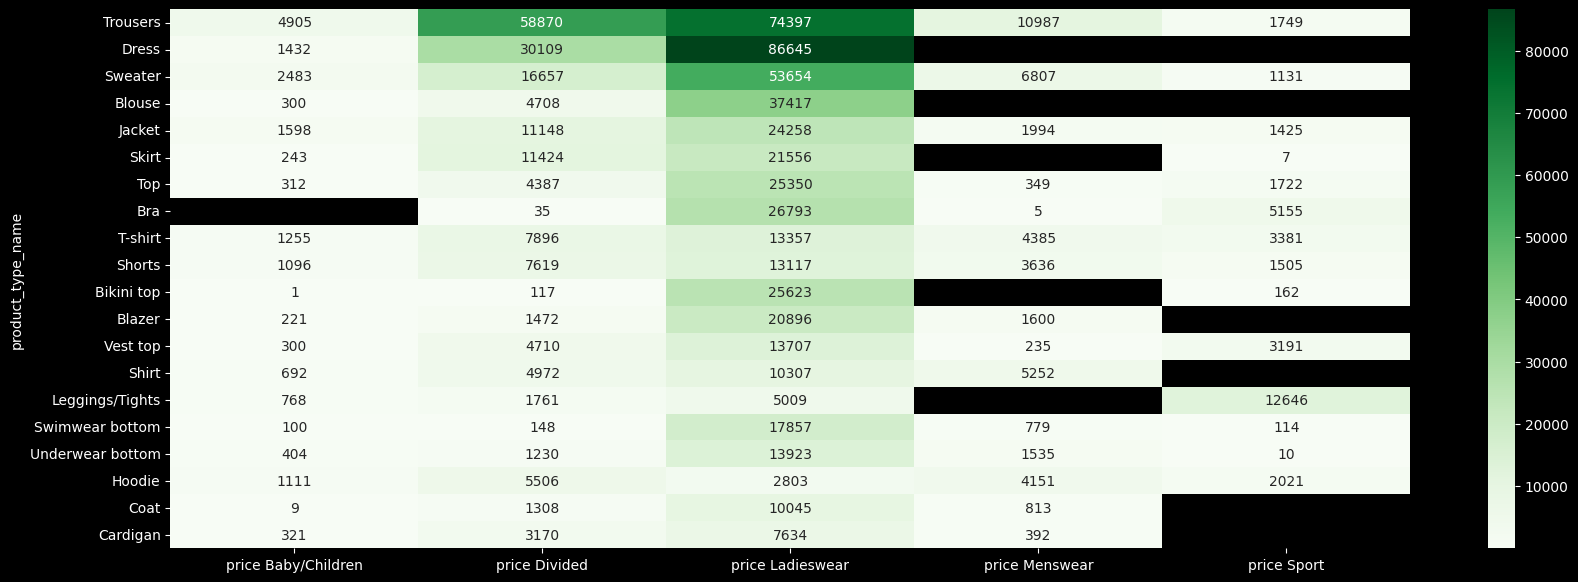

In [40]:
plt.figure(figsize=(20,7))
sns.heatmap(t[t.index.isin(top_10)], cmap='Greens', annot=True, fmt='.0f')

In [ ]:
df_trns[df_trns['product_type_name'] == 'Trousers'].plot(kind='scatter', x='price', y='t_dat', alpha=0.1)

In [ ]:
df_trns.head(3)

In [105]:
t = df_trns.groupby([pd.Grouper(key='t_dat', freq='M'), 'product_group_name'])['price'].sum().reset_index()

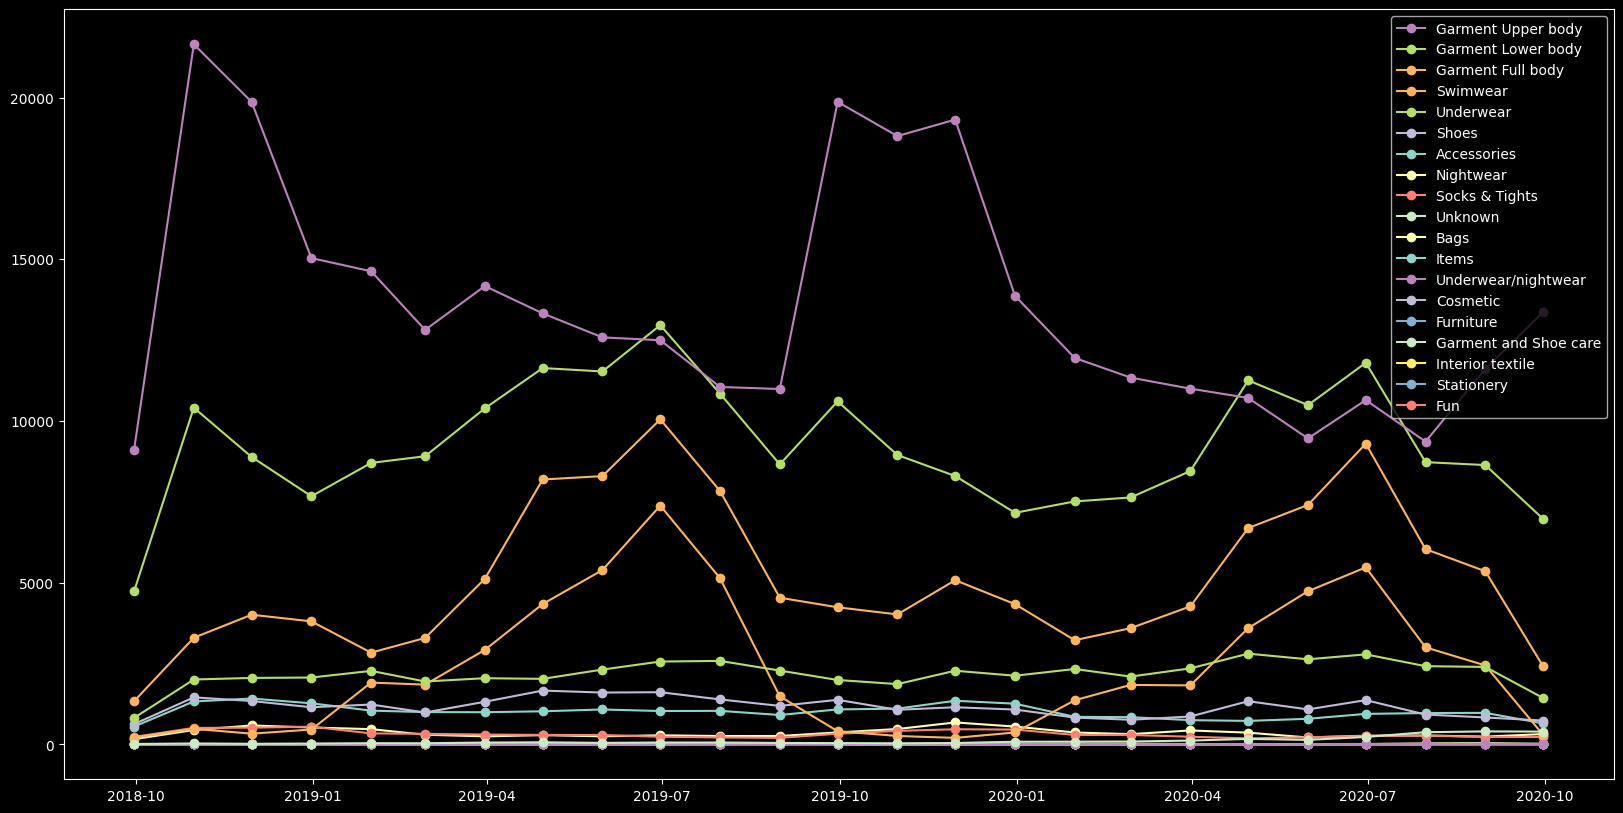

In [123]:
plt.figure(figsize=(20, 10))

for product_group_name, group in t.groupby('product_group_name'):
  plt.plot(group['t_dat'], group['price'], label=product_group_name, marker='o')


# Получение текущих обработчиков и меток
handles, labels = plt.gca().get_legend_handles_labels()
display(zip(labels, handles))

# Сортировка меток по убыванию значений
labels, handles = zip(*sorted(zip(labels, handles), key=lambda x: max(y1 + y2) - max(x[1].get_ydata()), reverse=False))

# Отображение легенды
plt.legend(handles, labels, loc='upper right')

#ML

In [ ]:
from sklearn.impute import SimpleImputer

si = SimpleImputer(strategy='most_frequent')

In [ ]:
df_cst['age 2'] = si.fit_transform(df_cst[['age']])

In [ ]:
si.statistics_

In [ ]:
df_cst[df_cst['age'].isna()]

In [ ]:
si.statistics_